# Fit a theoritical model to the autocorrelation derived from the idealized simulation
We define theoritcal models for the total autocorrelation and fit those models to our data to estimate the decorrelation timescale and amplitudes of the slow and fast components of our signal

In [1]:
import netCDF4 as nc

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal
import scipy
from inspect import signature

In [2]:
path = '/Users/zcaspar/codes/Diagnostics/'

In [3]:
corrL = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_drifters_corr_40avg1d.nc','ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

In [4]:
corrE = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_Eulerian_corr_40avg1d.nc','../ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

## Model fit : 

$\widetilde{C} = \widetilde{X}cos(\omega\tau)e^{-\tau/\tilde{T}}$\
$\overline{C} = \overline{X}cos(\Omega\tau)e^{-\tau/\bar{T}}$\
$C = \widetilde{C}+\overline{C}$

In [5]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Om):
    return np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar,Omega):
    return Xbar*Cbar(t,Tb,Omega)+Xtilde*Ctilde(t,Tt)

#### Notes :
In the autocorrelation we observed nodes in the uatocorrelation in some bins (cf notebook Correlations_comp.ipynb)
For now, the node is not taken into account in our models (no explaination and fit more difficult for the total signal)

In [6]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [90]:
# Parameters
myfunc = C #function to use for the fit
bounds = (0,(np.inf,np.inf,np.inf,np.inf,1)) # bounds for the fit to avoid non physical results

###  Average 1d removed to signal

In [28]:
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [29]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

In [47]:
# Parameters plot
lims_uu = [(0,25),(0,0.3),(0,25),(0,0.5),(-0.01,0.05)]
titles = [r'$\widetilde{T}$',r'$\widetilde{X}$',r'$\overline{T}$',r'$\overline{X}$',r'$\Omega$']

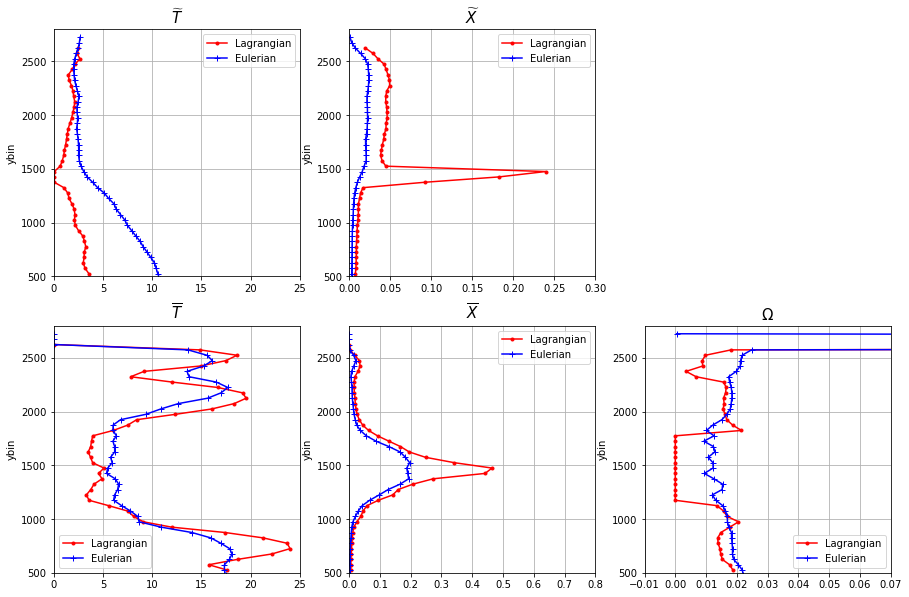

In [48]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims_vv[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

### Comments : 
Lagrangian (red lines) \
Decorrelation timescales, $\overline{T}$ and $\widetilde{T}$ (first column):\
both decrease from south to the jet then increase toward the north. $\widetilde{T}$goes to zero in the jet while $\overline{T}$ remains above $\simeq$3 days but shows strange local minima around 2300 km.\
Amplitudes, $\overline{X}$ and $\widetilde{X}$ (second column):\
$\widetilde{X}$ slowly increases with y with the exception of a few (4) high values (above 0.1) in the jet (correspond to the nul values of $\widetilde{T}$, certainly a best fit only found at saturation of $\widetilde{T}$ reaching the imposed lower bound, fit unefficient in this area)\
Eulerian\
Decorrelation timescales, $\overline{T}$ and $\widetilde{T}$ (first column):\
$\widetilde{T}$ decreases from high values in the south (24 days) to lower values in the north (threshold for y superior to 1500, middle of the jet).$\overline{T}$ follows the same sort of evolution than the lagrangian one with slightly higher values.\
Amplitudes, $\overline{X}$ and $\widetilde{X}$ (second column):\
Smoother version of the lagrangian.\

### Same but for the autocorrelation of v

In [44]:
lims_vv = [(0,25),(0,0.1),(0,25),(0,0.8),(-0.01,0.07)]

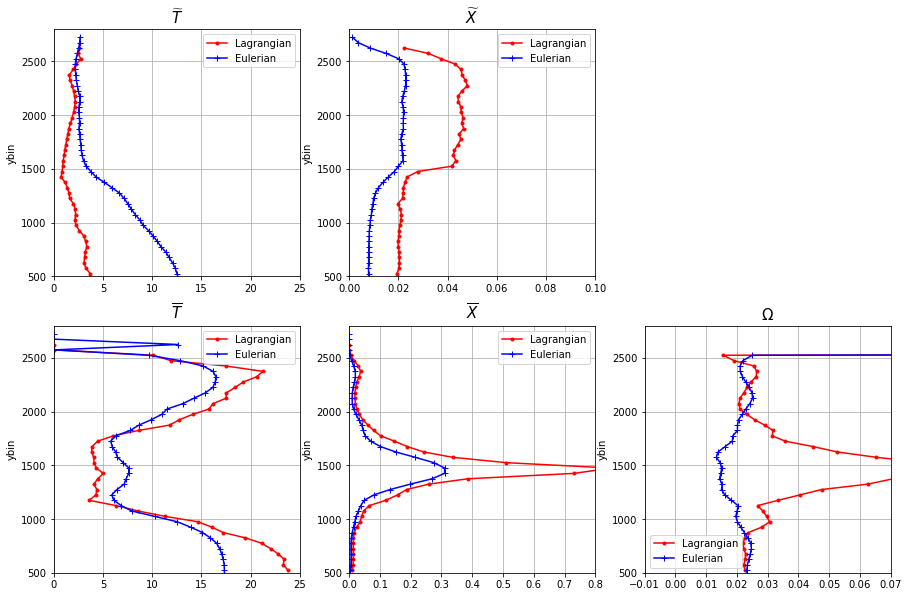

In [45]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims_vv[2:],axes[1,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

### Comments : 
We find results similar to the ones found for uu.\
In lagrangian, the main difference is the loss of the results we found strange in uu. No peaks in $\widetilde{X}$ and no saturation in $\widetilde{T}$ are observed. Otherwise similar values are found at the exception of $\overline{X}$ in eulerian and lagrangian with higher values in the jet area ($\geq$0.4 vs $\geq$0.8).

### Plot fit at 'strange' points in uu

Text(0.5, 1.0, 'vv')

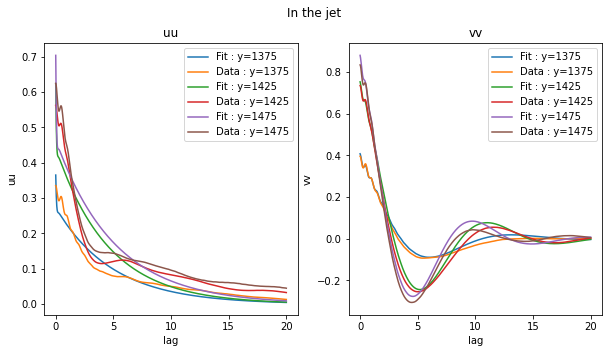

In [49]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
for Y in [1375,1425,1475]:
    out_combL_avg['uu'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[0],label='Fit : y=%s'%Y)
    corrL['avg1d']['uu'].sel(y_bins=Y).plot(ax=ax[0],label='Data : y=%s'%Y)
    out_combL_avg['vv'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[1],label='Fit : y=%s'%Y)
    corrL['avg1d']['vv'].sel(y_bins=Y).plot(ax=ax[1],label='Data : y=%s'%Y)
ax[0].legend();fig.suptitle('In the jet');ax[1].legend()
ax[0].set_title('uu');ax[1].set_title('vv')

### Comments : 
The autocorrelation of u is quite different between lags smaller than 3-4days and larger lags. The fit is not efficient as the function at smaller lags are not well represented due to the slower slope at larger lags.\
This proble is not encoutered in the autocorrelation of v as the data is a lot smoother than for u.

Text(0.5, 1.0, 'vv')

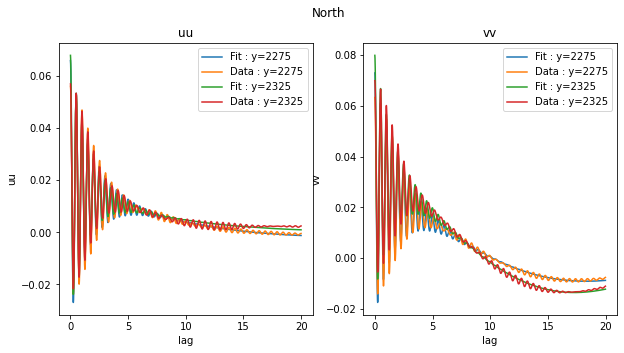

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
for Y in [2275,2325]:
    out_combL_avg['uu'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[0],label='Fit : y=%s'%Y)
    corrL['avg1d']['uu'].sel(y_bins=Y).plot(ax=ax[0],label='Data : y=%s'%Y)
    out_combL_avg['vv'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[1],label='Fit : y=%s'%Y)
    corrL['avg1d']['vv'].sel(y_bins=Y).plot(ax=ax[1],label='Data : y=%s'%Y)
ax[0].legend();fig.suptitle('North');ax[1].legend()
ax[0].set_title('uu');ax[1].set_title('vv')

### Total

In [23]:
out_combL,out_combE = {},{}
for V in ['uu','vv'] :
    out_combL[V] = xr.concat([fit(corrL['nada'][V].lag,corrL['nada'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['nada'][V].y_bins],dim='ybin')
    out_combE[V] = xr.concat([fit(corrE['nada'][V].lag,corrE['nada'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['nada'][V].y_bins],dim='ybin')

In [24]:
for V in ['uu','vv'] :
    out_combE[V] = out_combE[V].assign_coords({'ybin':out_combE[V].ybin.values*1e-3})

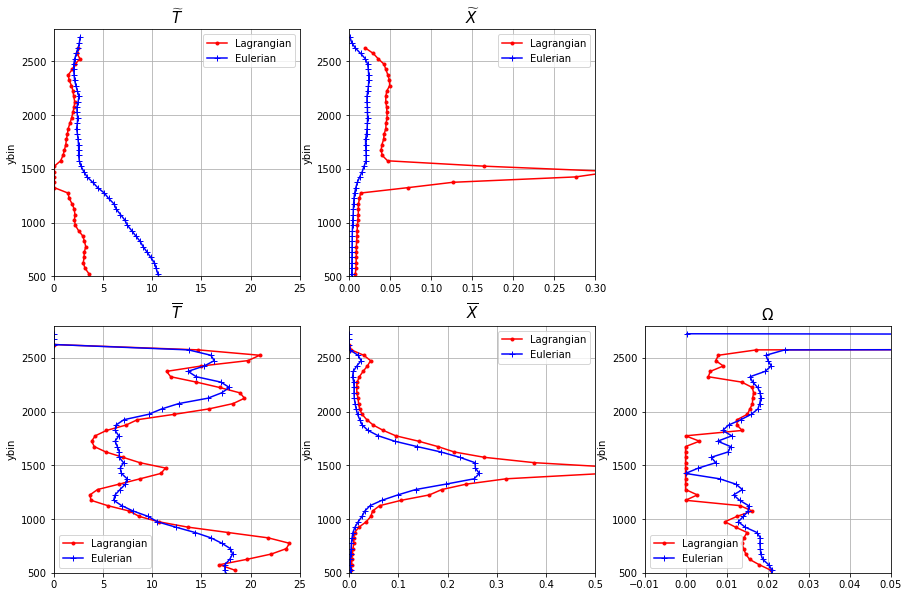

In [50]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE['uu'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims_uu[2:],axes[1,:]):
    out_combL['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE['uu'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

### Comments : 
No large differences in the fast compoent.\
Higher values for $\overline{X}$ than when we removed the average field.\
We observe a local maxima in the jet for $\overlien{T}$ in lagrangian.

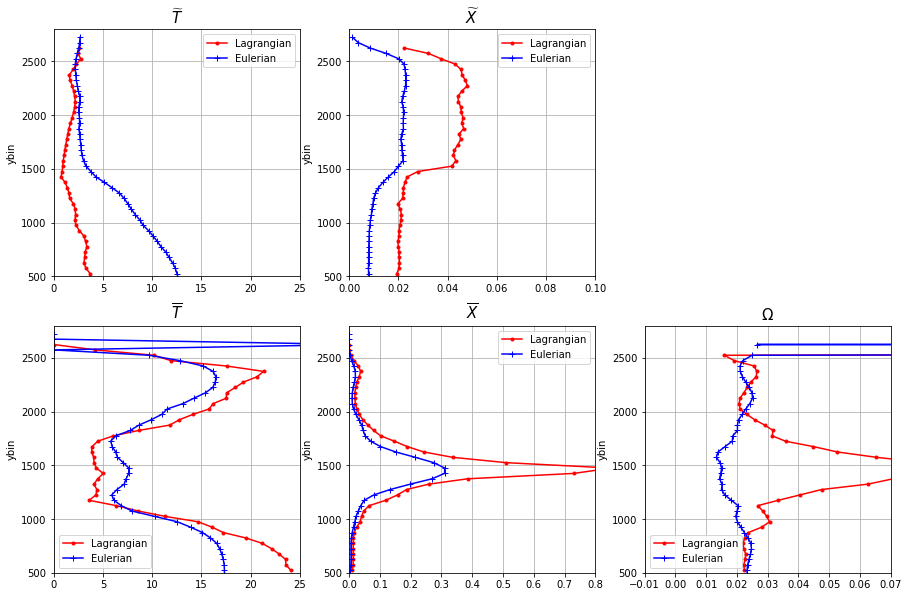

In [51]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE['vv'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims_vv[2:],axes[1,:]):
    out_combL['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE['vv'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

### Comments : 
No differences in vv

In [54]:
lims_uu = [(0,25),(0,0.8),(0,25),(0,0.8),(-0.01,0.07)]
lims_vv = [(0,25),(0,0.8),(0,25),(0,0.8),(-0.01,0.07)]

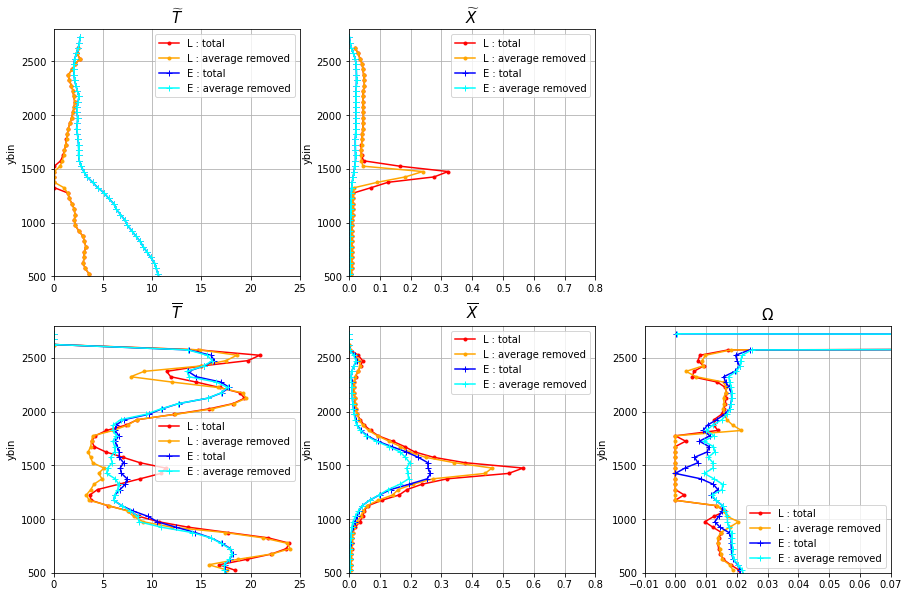

In [55]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL['uu'].params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE['uu'].params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims_uu[2:],axes[1,:]):
    out_combL['uu'].params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE['uu'].params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
fig.delaxes(axes[0,2])

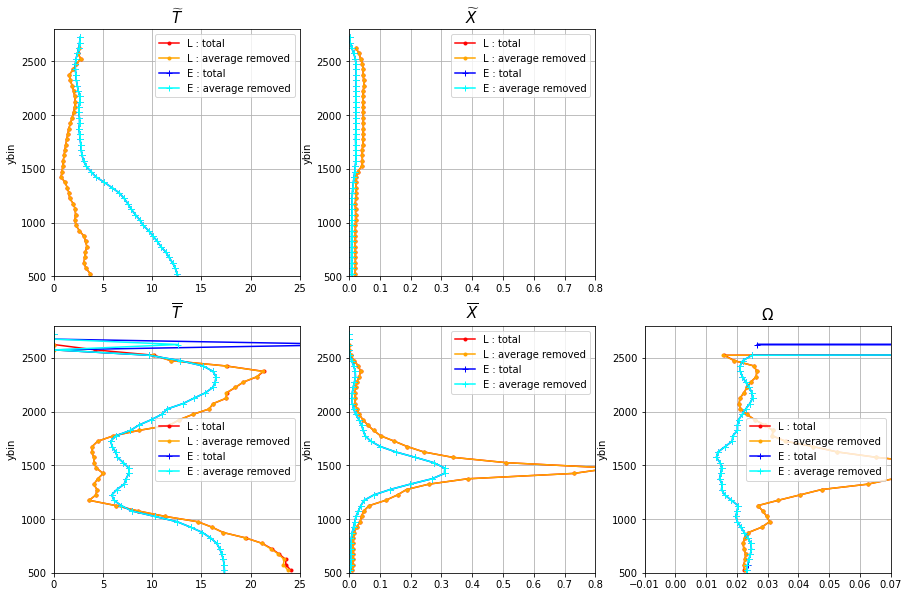

In [56]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL['vv'].params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE['vv'].params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims_vv[2:],axes[1,:]):
    out_combL['vv'].params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE['vv'].params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
fig.delaxes(axes[0,2])

### Comments : 
uu:\
No big differences between avg removed and total signal for the fast signal (which was expected).\
However in the jet the slow decorrelation timescale increases of more than 5 days in lagrangian and around 1-2 days in eulerian.\
vv : 
No differences observed for vv

## Changing paramters for better fit in uu

### Using a model without $\Omega$

In [58]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb):
    return np.exp(-t/Tb)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar):
    return Xbar*Cbar(t,Tb)+Xtilde*Ctilde(t,Tt)

myfunc = C

In [70]:
bounds = (0,np.inf)
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [71]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

In [74]:
lims_uu = [(0,15),(0,0.8),(0,15),(0,0.8)]
lims_vv = [(0,15),(0,0.8),(0,15),(0,0.8)]

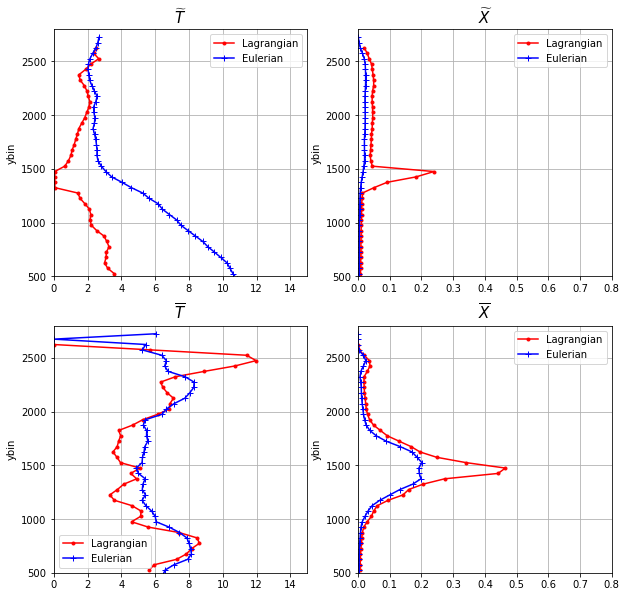

In [75]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_uu[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
The change of the theoretical model of the slow component does not seem to impact the results for $\wiedtilde{T}$, $\wiedtilde{X}$ and $\overline{X}$. Howerver the values of $\overline{T}$ are decreasedwith less variations in y and values more stable between " and 10 in the whole domain (vs 3 and 25 in the previous version of the theoretical model).

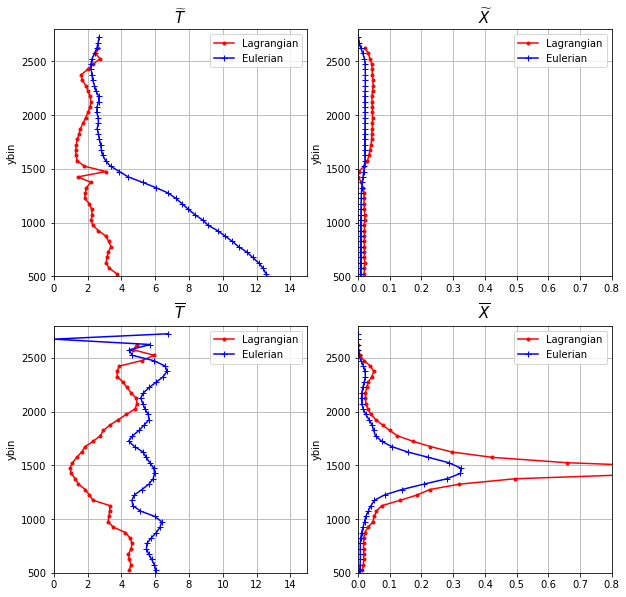

In [76]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_vv[2:],axes[1,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
The same impacts are observed in the autocorrelation of v with even more reduces variations of $\overline{T}$ ($\in[1;5]$ in lagrangian and $\in[4;7]$ i eulerian)

### Bounds of $\widetilde{T}$

In [77]:
bounds = ((1,0,0,0),np.inf)
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [78]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

In [79]:
lims_uu = [(0,15),(0,0.1),(0,15),(0,0.8)]
lims_vv = [(0,15),(0,0.1),(0,15),(0,0.8)]

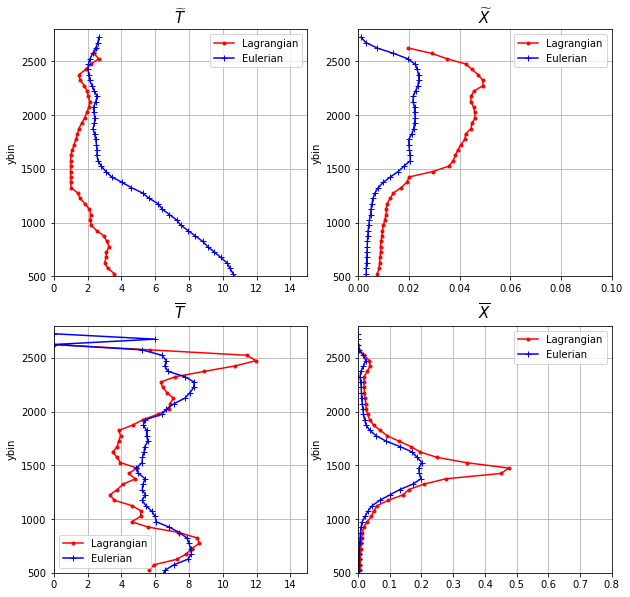

In [80]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_uu[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
Again the changes considering the parameters of one component does not seem to have impacts on the ones of the other component which is comforting concerning the fit.\
To set a lower bound for $\widetilde{T}$ at 1 day has for consequence to remove the peak in $\widetilde{X}$ in the jet area (middle of the domain). However, the results are saturated again in $\widetilde{T}$, the values being exactly at the lower bound.

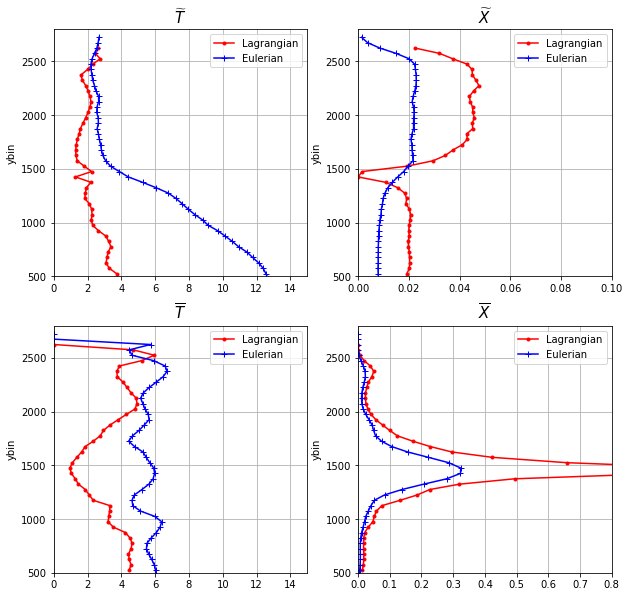

In [81]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_vv[2:],axes[1,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
Unfortunatley this bound has a nefast impact on the results found with the autocorrelation of v.\
This time we find 2 points with abrupt decrease of $\widetilde{X}$ toward values near 0 corresponding to  noisy points in $\widetilde{T}$.\
It might make more sense to either use only u or v or to define different bounds for each case.

Text(0.5, 1.0, 'vv')

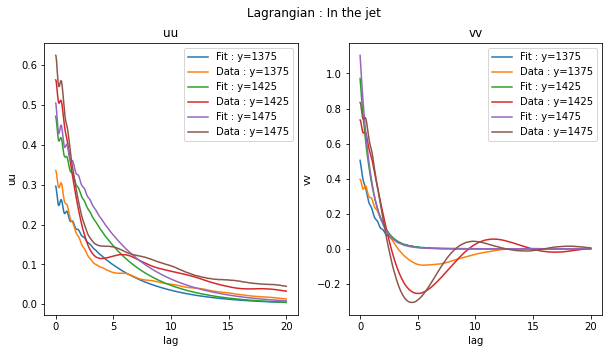

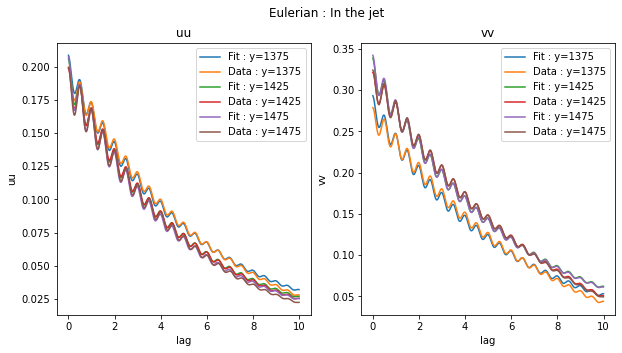

In [89]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
for Y in [1375,1425,1475]:
    out_combL_avg['uu'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[0],label='Fit : y=%s'%Y)
    corrL['avg1d']['uu'].sel(y_bins=Y).plot(ax=ax[0],label='Data : y=%s'%Y)
    out_combL_avg['vv'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[1],label='Fit : y=%s'%Y)
    corrL['avg1d']['vv'].sel(y_bins=Y).plot(ax=ax[1],label='Data : y=%s'%Y)
ax[0].legend();fig.suptitle('Lagrangian : In the jet');ax[1].legend()
ax[0].set_title('uu');ax[1].set_title('vv')

fig,ax = plt.subplots(1,2,figsize=(10,5))
for Y in [1375,1425,1475]:
    out_combE_avg['uu'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[0],label='Fit : y=%s'%Y)
    corrE['avg1d']['uu'].sel(y_bins=Y*1e3,method='nearest').plot(ax=ax[0],label='Data : y=%s'%Y)
    out_combE_avg['vv'].sel(param='Tt',ybin=Y).fitted.plot(ax=ax[1],label='Fit : y=%s'%Y)
    corrE['avg1d']['vv'].sel(y_bins=Y*1e3,method='nearest').plot(ax=ax[1],label='Data : y=%s'%Y)
ax[0].legend();fig.suptitle('Eulerian : In the jet');ax[1].legend()
ax[0].set_title('uu');ax[1].set_title('vv')

### Comments : 
A closer look to the data and corresponding best fit shows that, even though the results seemed better, the data is still not fitted very well in the autocorrelation of u. In the meantime, the data for v is not fitted correctly anymore.\
This comforts us in the idea that it would be best to ignore the jet area in the autocorrelation of u and to use only the parameters derived of the one of v at least in the part of domain.\
In eulerian, we don't seem have to take into account these kind of considerations since the best fits seem close to the original data for both u and v.

### Tl/Te relation

In [14]:
eulerian_field = xr.open_dataset(path+'Eulerian_field_ZC.nc')

In [15]:
zonal_avg = eulerian_field.mean('x_rho')

In [22]:
Umean = np.sqrt(zonal_avg.u_mean**2+zonal_avg.v_mean**2)

In [28]:
Lbc = 165*1e3
Tw = (24*3600)/2

Text(0.5, 1.0, '$\\widetilde{T_L}/\\widetilde{T_E}$')

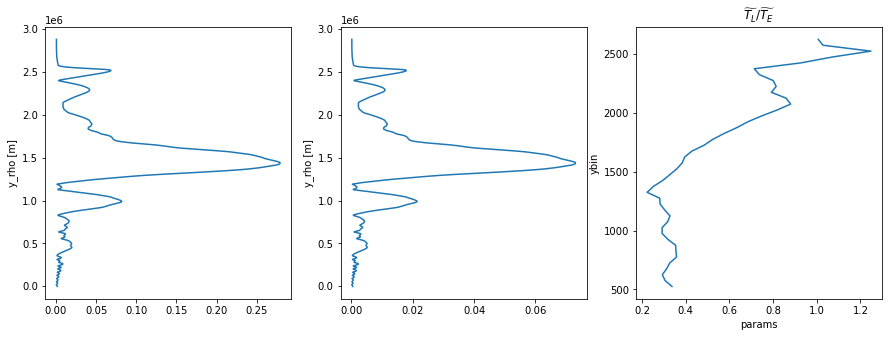

In [37]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
Umean.plot(y='y_rho',ax=axs[0])
(Umean*Tw/Lbc).plot(y='y_rho',ax=axs[1])
(out_combL.params.sel(param='Tt')/out_combE.params.sel(param='Tt')).plot(y='ybin',ax=axs[2])
axs[2].set_title(r'$\widetilde{T_L}/\widetilde{T_E}$')

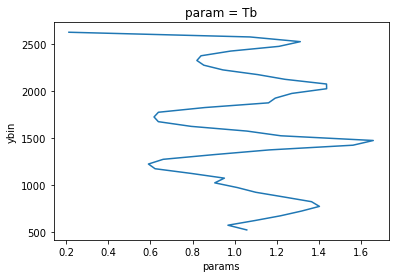

In [45]:
(out_combL.params.sel(param='Tb')/out_combE.params.sel(param='Tb')).plot(y='ybin')

In [55]:
# LaCasce
y = out_combL_avg['uu'].ybin.values
q = np.sqrt(np.pi/8)
beta = (Umean*Tw/Lbc)


0.9526578624013909


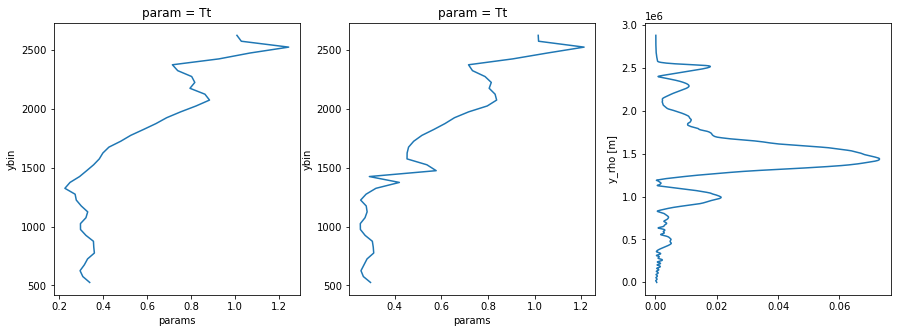

In [56]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
(out_combL_avg['uu'].params.sel(param='Tt')/out_combE_avg['uu'].params.sel(param='Tt')).plot(ax=ax[0],y='ybin')
(out_combL_avg['vv'].params.sel(param='Tt')/out_combE_avg['vv'].params.sel(param='Tt')).plot(ax=ax[1],y='ybin')
beta.plot(y='y_rho',ax=ax[2])
#ax.plot(f*y,y)
print(f)